In [1]:
# %%capture

In [16]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext sql
%sql duckdb:///:memory:

%reload_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Loading configurations from /home/jgafnea/Code2/trips-eda/pyproject.toml.

Settings changed:

Config,value
feedback,True
autopandas,True
displaylimit,100


In [17]:
%%sql
-- Create dimension table
CREATE OR REPLACE TABLE dim_zone_lookup AS
SELECT CAST("LocationID" AS INTEGER) AS LocationID, Borough, Zone
FROM read_csv_auto('https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv');

-- Load and normalize Yellow Taxi trips (staging tables, limit 100k per month)
CREATE OR REPLACE TABLE stg_yellow_2025_01 AS
SELECT CAST(tpep_pickup_datetime AS TIMESTAMP) AS pickup_datetime,
       CAST(tpep_dropoff_datetime AS TIMESTAMP) AS dropoff_datetime,
       CAST(PULocationID AS INTEGER) AS pickup_location_id,
       CAST(DOLocationID AS INTEGER) AS dropoff_location_id,
       CAST(passenger_count AS INTEGER) AS passenger_count,
       CAST(trip_distance AS DOUBLE) AS trip_distance,
       CAST(fare_amount AS DOUBLE) AS fare_amount,
       CAST(tip_amount AS DOUBLE) AS tip_amount,
       CAST(total_amount AS DOUBLE) AS total_amount,
       'yellow' AS taxi_type
FROM read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet')
WHERE passenger_count > 0 AND trip_distance > 0 AND fare_amount > 0 AND total_amount > 0
LIMIT 100000;

CREATE OR REPLACE TABLE stg_yellow_2025_02 AS
SELECT CAST(tpep_pickup_datetime AS TIMESTAMP) AS pickup_datetime,
       CAST(tpep_dropoff_datetime AS TIMESTAMP) AS dropoff_datetime,
       CAST(PULocationID AS INTEGER) AS pickup_location_id,
       CAST(DOLocationID AS INTEGER) AS dropoff_location_id,
       CAST(passenger_count AS INTEGER) AS passenger_count,
       CAST(trip_distance AS DOUBLE) AS trip_distance,
       CAST(fare_amount AS DOUBLE) AS fare_amount,
       CAST(tip_amount AS DOUBLE) AS tip_amount,
       CAST(total_amount AS DOUBLE) AS total_amount,
       'yellow' AS taxi_type
FROM read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-02.parquet')
WHERE passenger_count > 0 AND trip_distance > 0 AND fare_amount > 0 AND total_amount > 0
LIMIT 100000;

CREATE OR REPLACE TABLE stg_yellow_2025_03 AS
SELECT CAST(tpep_pickup_datetime AS TIMESTAMP) AS pickup_datetime,
       CAST(tpep_dropoff_datetime AS TIMESTAMP) AS dropoff_datetime,
       CAST(PULocationID AS INTEGER) AS pickup_location_id,
       CAST(DOLocationID AS INTEGER) AS dropoff_location_id,
       CAST(passenger_count AS INTEGER) AS passenger_count,
       CAST(trip_distance AS DOUBLE) AS trip_distance,
       CAST(fare_amount AS DOUBLE) AS fare_amount,
       CAST(tip_amount AS DOUBLE) AS tip_amount,
       CAST(total_amount AS DOUBLE) AS total_amount,
       'yellow' AS taxi_type
FROM read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-03.parquet')
WHERE passenger_count > 0 AND trip_distance > 0 AND fare_amount > 0 AND total_amount > 0
LIMIT 100000;

-- Merge staging tables into intermediate table
CREATE OR REPLACE TABLE int_trips AS
SELECT * FROM stg_yellow_2025_01
UNION ALL
SELECT * FROM stg_yellow_2025_02
UNION ALL
SELECT * FROM stg_yellow_2025_03;

-- Enrich with zone info
CREATE OR REPLACE TABLE fct_trips AS
SELECT t.*,
       zpu.Borough AS pickup_borough,
       zpu.Zone AS pickup_zone,
       zdo.Borough AS dropoff_borough,
       zdo.Zone AS dropoff_zone
FROM int_trips t
LEFT JOIN dim_zone_lookup zpu ON t.pickup_location_id = zpu.LocationID
LEFT JOIN dim_zone_lookup zdo ON t.dropoff_location_id = zdo.LocationID;

SELECT 'SUCCESS' AS status;

Running query in 'duckdb:///:memory:'

,status
0,SUCCESS


In [18]:
# Load into pandas
df = %sql SELECT * FROM fct_trips;

# TODO: Note config 'autopandas'
df.info()

Running query in 'duckdb:///:memory:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   pickup_datetime      300000 non-null  datetime64[us]
 1   dropoff_datetime     300000 non-null  datetime64[us]
 2   pickup_location_id   300000 non-null  int32         
 3   dropoff_location_id  300000 non-null  int32         
 4   passenger_count      300000 non-null  int32         
 5   trip_distance        300000 non-null  float64       
 6   fare_amount          300000 non-null  float64       
 7   tip_amount           300000 non-null  float64       
 8   total_amount         300000 non-null  float64       
 9   taxi_type            300000 non-null  object        
 10  pickup_borough       300000 non-null  object        
 11  pickup_zone          300000 non-null  object        
 12  dropoff_borough      300000 non-null  object        
 13  dropoff_zone  

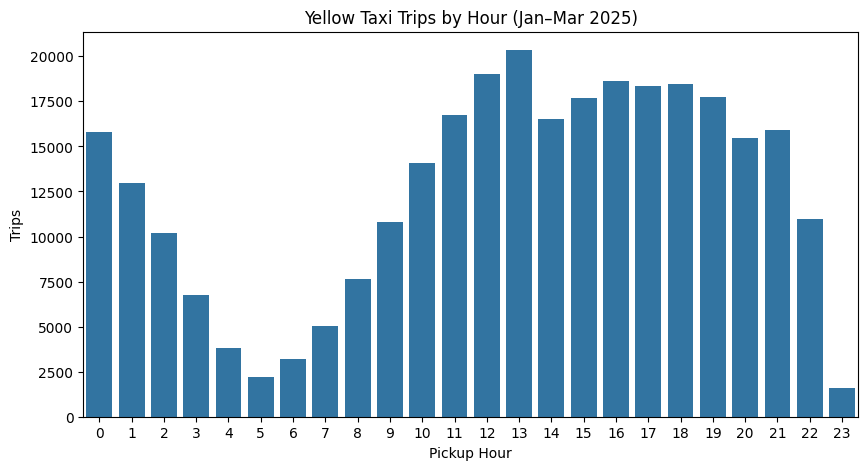

In [19]:
# Hourly volume
df['pickup_hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
hourly_counts = df.groupby('pickup_hour').size().reset_index(name='trip_count')
plt.figure(figsize=(10,5))
sns.barplot(x='pickup_hour', y='trip_count', data=hourly_counts)
plt.title('Yellow Taxi Trips by Hour (Jan–Mar 2025)')
plt.xlabel('Pickup Hour')
plt.ylabel('Trips')
plt.xticks(range(0,24))
plt.show()

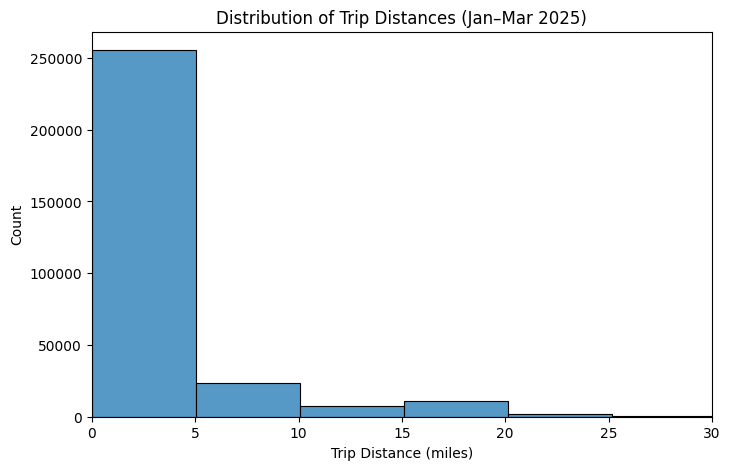

In [20]:
# Distance distribution
plt.figure(figsize=(8,5))
sns.histplot(df['trip_distance'], bins=50)
plt.title('Distribution of Trip Distances (Jan–Mar 2025)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Count')
plt.xlim(0,30)
plt.show()

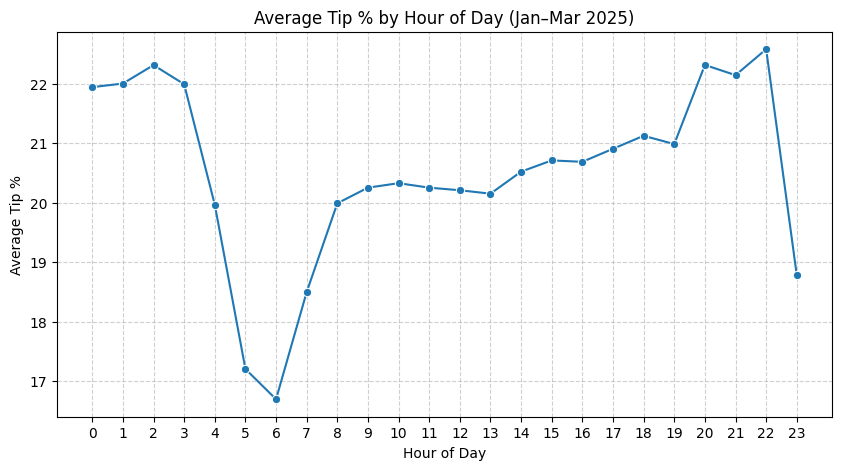

In [22]:
# Tip% distribution
# print(df.groupby('pickup_hour')['tip_percent'].agg(['mean','count']))

# Ensure pickup_hour exists
df['pickup_hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
df['tip_percent'] = (df['tip_amount'] / df['fare_amount']) * 100
hourly_tips = df.groupby('pickup_hour')['tip_percent'].mean().reset_index()

# Create figure first
plt.figure(figsize=(10,5))
sns.lineplot(x='pickup_hour', y='tip_percent', data=hourly_tips, marker='o')

plt.title("Average Tip % by Hour of Day (Jan–Mar 2025)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Tip %")
plt.xticks(range(0,24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


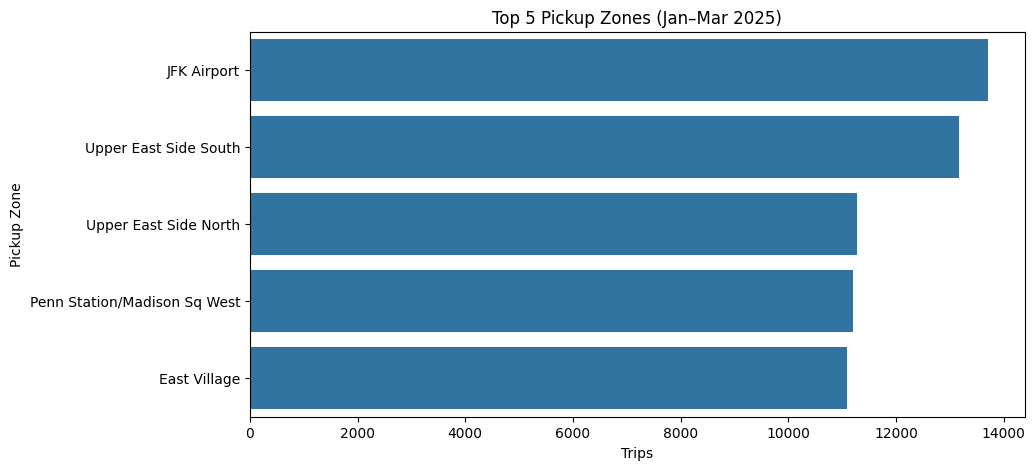

In [23]:
# Top pickup zones
top_pickups = (
    df['pickup_zone']
    .value_counts()
    .head(5)
    .reset_index()
)
top_pickups.columns = ['pickup_zone', 'trip_count']  # make sure columns are exactly these names

plt.figure(figsize=(10,5))
sns.barplot(y='pickup_zone', x='trip_count', data=top_pickups)
plt.title("Top 5 Pickup Zones (Jan–Mar 2025)")
plt.xlabel("Trips")
plt.ylabel("Pickup Zone")
plt.show()